In [1]:
import numpy as np
import scipy.linalg as linalg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#function to estimate the correspondences and outputs the list of correspondences between the 2 point clouds 
def EstimateCorrespondences(X,Y,t,R,dmax):
    C = np.empty((0,2), dtype=int)
    #transformed pointcloud
    x_t = np.dot(X, R) + t
    for i in range(len(X)):
        j = 0
        j = np.argmin(np.linalg.norm(Y - x_t[i], axis=1))
        if(np.linalg.norm(x_t[i] - Y[j]) < dmax):
            C = np.vstack((C, [i, j]))
    return(C)

In [3]:
#function that computes the affine transformation for the 2 pointclouds and returns the rotation and translation components
def ComputeOptimalRigidRegistration(X, Y, C):
    k = len(C)

    x = X[C[:,0]]
    y = Y[C[:,1]] 

    x_centre = np.mean(x, axis=0)
    y_centre = np.mean(y, axis=0)

    x_dev = x - x_centre
    y_dev = y - y_centre
    
    W = np.zeros((3,3))
    
    #co-variance matrix
    for i in range(k):
        W += np.outer(x_dev[i], y_dev[i])

    #SVD operation on the co-variance matrix
    U, S, V = np.linalg.svd(W)

    #finding the corresponding rotation and translation
    R_cap = np.dot(U, V)
    t_cap = y_centre - np.dot(x_centre, R_cap)

    return(t_cap,R_cap)

In [4]:
def ICP(X, Y, t0, R0, dmax, num_ICP_iters):
    t, R = t0, R0
    for i in range(num_ICP_iters):
        C = EstimateCorrespondences(X, Y, t, R, dmax)
        t, R = ComputeOptimalRigidRegistration(X, Y, C)
    return(t, R, C)

In [5]:
X = np.loadtxt('pclX.txt')
Y = np.loadtxt('pclY.txt')
t0 = np.zeros(3)
R0 = np.eye(3)
dmax = 0.25
num_ICP_iters = 30
t, R, C = ICP(X, Y, t0, R0, dmax, num_ICP_iters)

In [8]:
#RMSE calculation
X_t = np.dot(X,R) + t
s = np.mean(linalg.norm(Y - X_t, axis=1)**2)
RMSE = np.sqrt(s)

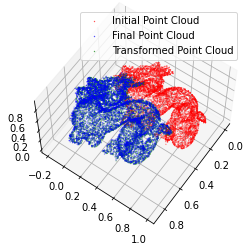

optimal translation: [ 0.49661487 -0.29392971  0.29645004] 
 optimal rotation: 
 [[ 0.95126601  0.22323628  0.21274056]
 [-0.15043058  0.9381636  -0.31180074]
 [-0.26919069  0.26460276  0.92602471]] 
 root mean square error: 0.4604336069962269


In [9]:
#Plotting of the figures
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c='r', s=0.1, label='Initial Point Cloud')
ax.scatter(Y[:, 0], Y[:, 1], Y[:, 2], c='b', s=0.1, label='Final Point Cloud')
ax.scatter(X_t[:, 0], X_t[:, 1], X_t[:, 2], c='g', s=0.1, label='Transformed Point Cloud')
ax.legend()
ax.view_init(60, 35)
plt.show()
print('optimal translation:', t, '\n', 'optimal rotation:', '\n', R, '\n', 'root mean square error:', RMSE)